In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.feature import local_binary_pattern

from skimage import exposure


# Final project - RSB

## Notebook goals

This notebook implements and compares **face recognition pipelines** on a small celebrity dataset (**17 identities × ~100 images each**).

We evaluate two tasks:

- **Identification (1:N)**: *“Who is this person?”* → reported with **accuracy**.
- **Verification (1:1)**: *“Are these two images the same person?”* → reported with **ROC/AUC** and **EER** (plus FAR/FRR at EER).

Compared methods:

- **Classic descriptors**: LBP + SVM, HOG + SVM  
- **Classic + detection pre-step**: Viola–Jones crop + (LBP/HOG)  
- **Deep embeddings**: DeepFace (Facenet512, ArcFace)

> Important context: the dataset contains **full photos** (background + outfits). This is intentionally challenging for classical descriptors, and it explains the gap vs deep models.


In [46]:
# import my dataset from drive after mounting it
ds_path = "/content/drive/MyDrive/Celebrity Faces Dataset"
import os

In [47]:
# init result dict ... used to compare at the end
results = {
    "meta": {
        "dataset": None,
        "n_images": None,
        "n_identities": None,
        "img_size": None,
        "split": None
    },
    "methods": {}
}

def init_method(results, name, kind):
    '''
    Register a method entry in the global `results` dictionary.

    Args:
      results: Global results dict containing keys `meta` and `methods`.
      name: Method name (used as a key), e.g. "LBP+SVM".
      kind: "classic" or "deep" (used later for grouping/comparison).

    Returns:
      None. (The function updates `results` in-place.)
    '''
    results["methods"][name] = {
        "kind": kind,  # "classic" or "deep"
        "identification": {},
        "verification": {},
        "runtime_ms": {}
    }


In [48]:
init_method(results, "LBP+SVM", "classic")
init_method(results, "HOG+SVM", "classic")
init_method(results, "DeepFace-Facenet512", "deep")
init_method(results, "DeepFace-ArcFace", "deep")

In [49]:
# trying loading the dataset well, particular architecture of the img by celebrity
print("DATA_ROOT exists:", os.path.exists(ds_path))
print("Example children:", os.listdir(ds_path)[:10])

DATA_ROOT exists: True
Example children: ['Brad Pitt', 'Jennifer Lawrence', 'Denzel Washington', 'Kate Winslet', 'Angelina Jolie', 'Hugh Jackman', 'Johnny Depp', 'Natalie Portman', 'Megan Fox', 'Leonardo DiCaprio']


In [50]:
import glob

exts = (".jpg", ".jpeg", ".png", ".webp")

image_paths = []
labels = []

# folders = each celebrity
for celeb_dir in sorted([d for d in glob.glob(os.path.join(ds_path, "*")) if os.path.isdir(d)]):
    celeb_name = os.path.basename(celeb_dir)  # keeps spaces
    for root, _, files in os.walk(celeb_dir):
        for f in files:
            if f.lower().endswith(exts):
                image_paths.append(os.path.join(root, f))
                labels.append(celeb_name)

print("Total images:", len(image_paths))
print("Total identities:", len(set(labels)))


Total images: 1800
Total identities: 17


### Dataset summary
We scan the dataset folder structure:

```
root/
  Celebrity A/
    img1.jpg ...
  Celebrity B/
    ...
```

Each folder name is the **identity label**. We keep labels as folder names (including spaces) to avoid accidental label corruption.


In [51]:
# build up the pipeline
from sklearn.model_selection import train_test_split

X_paths = image_paths
y = labels

train_paths, test_paths, y_train, y_test = train_test_split(
    X_paths, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train:", len(train_paths), "Test:", len(test_paths))
print("Train identities:", len(set(y_train)), "Test identities:", len(set(y_test)))


Train: 1260 Test: 540
Train identities: 17 Test identities: 17


### Train/test split choice
We use a **stratified split** to keep the same identity distribution in train and test.

- `test_size=0.3`
- `random_state=42`

This is required for fair comparison across methods.


In [52]:
IMG_SIZE = (128, 128)  # good for HOG/LBP speed
results["meta"]["img_size"] = IMG_SIZE

P, R = 8, 1  # neighbors, and radius
LBP_METHOD = "uniform"

# helper to load_gray, good for HOG and LBP
def load_gray(path):
    '''
    Load an image from disk and convert it to grayscale.

    Args:
      path: Path to an image file.

    Returns:
      gray: 2D numpy array (H, W) with grayscale pixel intensities (0..255).
    '''
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

# helper to resize
def resize(img, size=IMG_SIZE):
    '''
    Resize an image to a fixed size (default: IMG_SIZE).

    Args:
      img: 2D (grayscale) or 3D (color) numpy array.
      size: Target (width, height) or (H, W) as expected by OpenCV resize.

    Returns:
      resized: Image resized to `size`.
    '''
    return cv2.resize(img, size)

# helper to extract LBP features
def extract_lbp(img, P=P, R=R, method=LBP_METHOD):
    '''
    Compute the Local Binary Pattern (LBP) code image.

    Args:
      img: Grayscale image (2D array).
      P: Number of neighbors.
      R: Radius.
      method: LBP variant (we use 'uniform').

    Returns:
      lbp: 2D array of LBP codes (same H, W as input).
    '''
    return local_binary_pattern(img, P, R, method=method)

def hist_lbp(lbp):
  '''
  Convert an LBP code image into a normalized histogram feature vector.

  Args:
    lbp: 2D array of LBP codes.

  Returns:
    hist: 1D numpy array (feature vector) representing the distribution of LBP patterns.
  '''
  n_bins = int(lbp.max() + 1)
  hist, _ = np.histogram(
      lbp.ravel(),
      bins=n_bins,
      range=(0, n_bins),
      density=True
  )
  return hist


In [53]:
# Build features for train/test (LBP)
import time

def build_lbp_features(paths):
    '''
    Extract LBP histogram features for a list of image paths.

    Pipeline per image:
      load_gray -> resize -> extract_lbp -> hist_lbp

    Args:
      paths: List of image paths.

    Returns:
      feats: 2D array of shape (N, D) where D is histogram length.
      ms_per_img: Average extraction time per image (milliseconds).
    '''
    feats = []
    t0 = time.time()
    for p in paths:
        gray = load_gray(p)
        gray = resize(gray)
        lbp = extract_lbp(gray)
        hist = hist_lbp(lbp)
        feats.append(hist)
    feats = np.vstack(feats)
    ms_per_img = (time.time() - t0) * 1000 / len(paths)
    return feats, ms_per_img


X_train_lbp, ms_train = build_lbp_features(train_paths)
X_test_lbp, ms_test = build_lbp_features(test_paths)

print("X_train_lbp shape:", X_train_lbp.shape)
print("X_test_lbp shape:", X_test_lbp.shape)
print("LBP ms/img (train):", round(ms_train, 2))
print("LBP ms/img (test):", round(ms_test, 2))

X_train_lbp shape: (1260, 10)
X_test_lbp shape: (540, 10)
LBP ms/img (train): 18.26
LBP ms/img (test): 10.36


In [54]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

clf_lbp = LinearSVC()
t0 = time.time()
clf_lbp.fit(X_train_lbp, y_train)
svm_train_ms = (time.time() - t0) * 1000 / len(y_train)

y_pred = clf_lbp.predict(X_test_lbp)
acc = accuracy_score(y_test, y_pred)

print("LBP + SVM accuracy:", acc)

LBP + SVM accuracy: 0.13148148148148148


In [55]:
results["methods"]["LBP+SVM"]["identification"]["accuracy"] = float(acc)
results["methods"]["LBP+SVM"]["runtime_ms"]["feature_train"] = float(ms_train)
results["methods"]["LBP+SVM"]["runtime_ms"]["feature_test"] = float(ms_test)
results["methods"]["LBP+SVM"]["runtime_ms"]["svm_train"] = float(svm_train_ms)

### Interpretation — LBP identification
If the identification accuracy is low, this is expected on **uncropped celebrity photos**:

- LBP encodes **local texture patterns** (including clothes/background).
- In unconstrained images, texture is not stable across photos of the same person.
- Therefore, LBP struggles for multi-class identification (17-way classification).

This does *not* automatically contradict verification metrics: **verification is a different task** (binary same/different) and can behave differently.


LBP for verification

In [56]:
import numpy as np
from collections import defaultdict

def make_pairs(labels, max_genuine_per_id=200, max_impostor=5000, seed=42):
    '''
    Create labeled pairs for verification evaluation.

    A 'genuine' pair has the same identity label (1),
    an 'impostor' pair has different labels (0).

    We sample pairs to avoid O(N^2) explosion.

    Args:
      labels: List of identity labels aligned with a feature matrix (same indexing).
      max_genuine_per_id: Number of genuine pairs sampled per identity.
      max_impostor: Total number of impostor pairs sampled.
      seed: Random seed for reproducibility.

    Returns:
      pairs: List of tuples (i, j, same) where i and j are indices into the dataset,
             and same is 1 (genuine) or 0 (impostor).
    '''
    rng = np.random.default_rng(seed)

    by_id = defaultdict(list)
    for i, lab in enumerate(labels):
        by_id[lab].append(i)

    # genuine pairs (same identity)
    genuine = []
    for lab, idxs in by_id.items():
        if len(idxs) < 2:
            continue
        idxs = np.array(idxs)
        for _ in range(max_genuine_per_id):
            i, j = rng.choice(idxs, size=2, replace=False)
            genuine.append((i, j, 1))

    # impostor pairs (different identities)
    all_idx = np.arange(len(labels))
    impostor = []
    while len(impostor) < max_impostor:
        i, j = rng.choice(all_idx, size=2, replace=False)
        if labels[i] != labels[j]:
            impostor.append((i, j, 0))

    pairs = genuine + impostor
    rng.shuffle(pairs)
    return pairs

pairs = make_pairs(y_test, max_genuine_per_id=200, max_impostor=5000, seed=42)
print("Total pairs:", len(pairs))
print("Genuine:", sum(s for _,_,s in pairs), "| Impostor:", len(pairs) - sum(s for _,_,s in pairs))


Total pairs: 8400
Genuine: 3400 | Impostor: 5000


In [57]:
def pair_scores(features, pairs):
    '''
    Compute similarity scores for verification from a feature matrix.

    We use negative Euclidean distance as a similarity score:
      score = -||x_i - x_j||.
    Higher score => more similar.

    Args:
      features: 2D array (N, D), one feature vector per image.
      pairs: Output of `make_pairs`.

    Returns:
      scores: 1D array of similarity scores (float).
      y_true: 1D array of ground-truth labels (1 genuine, 0 impostor).
    '''
    scores = []
    y_true = []
    for i, j, same in pairs:
        d = np.linalg.norm(features[i] - features[j])
        scores.append(-d)   # similarity
        y_true.append(same) # 1 genuine, 0 impostor
    return np.array(scores), np.array(y_true)

scores, y_true = pair_scores(X_test_lbp, pairs)

print("Scores shape:", scores.shape)
print("y_true mean (genuine ratio):", y_true.mean())


Scores shape: (8400,)
y_true mean (genuine ratio): 0.40476190476190477


ROC, AUC, EER

In [58]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fpr - fnr))
eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
eer_thr = thresholds[eer_idx]

print("AUC:", roc_auc)
print("EER:", eer)
print("EER threshold:", eer_thr)


AUC: 0.5144517352941176
EER: 0.4919294117647059
EER threshold: -0.11647417403749304


FAR/FRR at the EER threshold

In [59]:
far_at_eer = float(fpr[eer_idx])
frr_at_eer = float(fnr[eer_idx])

print("FAR@EER:", far_at_eer)
print("FRR@EER:", frr_at_eer)

results["methods"]["LBP+SVM"]["verification"]["auc"] = float(roc_auc)
results["methods"]["LBP+SVM"]["verification"]["eer"] = float(eer)
results["methods"]["LBP+SVM"]["verification"]["eer_threshold"] = float(eer_thr)
results["methods"]["LBP+SVM"]["verification"]["far_at_eer"] = far_at_eer
results["methods"]["LBP+SVM"]["verification"]["frr_at_eer"] = frr_at_eer


FAR@EER: 0.4918
FRR@EER: 0.49205882352941177


ROC

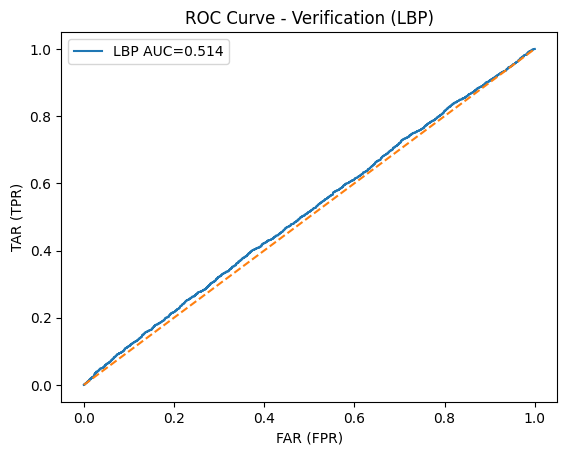

In [60]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"LBP AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FAR (FPR)")
plt.ylabel("TAR (TPR)")
plt.title("ROC Curve - Verification (LBP)")
plt.legend()
plt.show()


# HOG

In [61]:
import cv2
import numpy as np

hog = cv2.HOGDescriptor(
    _winSize=(128, 128),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9
)


In [62]:
import time

def build_hog_features(paths):
    '''
    Extract HOG features for a list of image paths (OpenCV HOGDescriptor).

    Pipeline per image:
      load_gray -> resize -> hog.compute -> flatten

    Args:
      paths: List of image paths.

    Returns:
      feats: 2D array of shape (N, D).
      ms_per_img: Average extraction time per image (milliseconds).
    '''
    feats = []
    t0 = time.time()
    for p in paths:
        gray = load_gray(p)
        gray = resize(gray)
        h = hog.compute(gray)
        feats.append(h.reshape(-1))
    feats = np.vstack(feats)
    ms_per_img = (time.time() - t0) * 1000 / len(paths)
    return feats, ms_per_img


In [63]:
X_train_hog, ms_train_hog = build_hog_features(train_paths)
X_test_hog, ms_test_hog = build_hog_features(test_paths)

print("X_train_hog shape:", X_train_hog.shape)
print("X_test_hog shape:", X_test_hog.shape)
print("HOG ms/img (train):", round(ms_train_hog, 2))
print("HOG ms/img (test):", round(ms_test_hog, 2))


X_train_hog shape: (1260, 8100)
X_test_hog shape: (540, 8100)
HOG ms/img (train): 6.52
HOG ms/img (test): 4.73


In [64]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

clf_hog = LinearSVC()
t0 = time.time()
clf_hog.fit(X_train_hog, y_train)
svm_train_ms_hog = (time.time() - t0) * 1000 / len(y_train)

y_pred_hog = clf_hog.predict(X_test_hog)
acc_hog = accuracy_score(y_test, y_pred_hog)

print("HOG + SVM accuracy:", acc_hog)


HOG + SVM accuracy: 0.27037037037037037


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Interpretation : HOG identification
HOG typically performs better than LBP here because it captures **edge/shape information** (face contours, eye/nose edges) rather than pure texture.

However, because faces are not guaranteed to be centered or dominant in the frame, HOG can still encode strong edges from the background.


In [65]:
results["methods"]["HOG+SVM"]["identification"]["accuracy"] = float(acc_hog)
results["methods"]["HOG+SVM"]["runtime_ms"]["feature_train"] = float(ms_train_hog)
results["methods"]["HOG+SVM"]["runtime_ms"]["feature_test"] = float(ms_test_hog)
results["methods"]["HOG+SVM"]["runtime_ms"]["svm_train"] = float(svm_train_ms_hog)


Viola Jones to crop faces

In [67]:
import cv2

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

print("Cascade loaded:", not face_cascade.empty())


Cascade loaded: True


In [68]:
def crop_face_vj(gray):
    '''
    Crop the largest detected face using Viola–Jones (Haar cascade).

    If no face is detected, the function returns the original grayscale image.
    This makes the pipeline robust to detection failures, but can create
    inconsistent inputs (cropped vs full image), which may impact accuracy.

    Args:
      gray: Grayscale image (2D array).

    Returns:
      face_gray: Cropped face region (2D array) or the original image if no face is found.
    '''
    # detect faces
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    if len(faces) == 0:
        return gray  # fallback: no face found

    # even tho in our current ds it's mostly 1 person
    x, y, w, h = max(faces, key=lambda b: b[2] * b[3])

    face = gray[y:y+h, x:x+w]
    return face


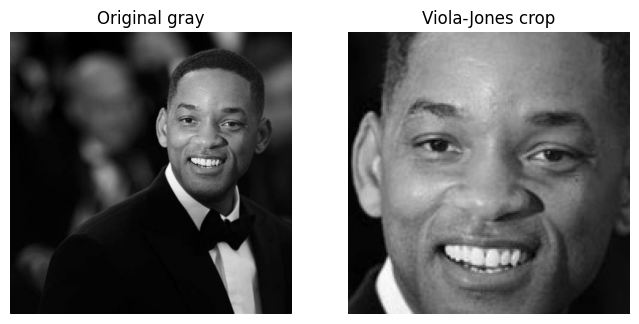

Label: Will Smith


In [69]:
import random
import matplotlib.pyplot as plt

idx = random.randrange(len(train_paths))
g = load_gray(train_paths[idx])
face = crop_face_vj(g)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(g, cmap="gray")
plt.title("Original gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(face, cmap="gray")
plt.title("Viola-Jones crop")
plt.axis("off")

plt.show()
print("Label:", y_train[idx])


In [72]:
# applying cropping on old classic methods

import time
import numpy as np

def build_lbp_features_vj(paths):
    '''
    Extract LBP histogram features with an extra face-cropping step (Viola–Jones).

    Pipeline per image:
      load_gray -> crop_face_vj -> resize -> extract_lbp -> hist_lbp

    Args:
      paths: List of image paths.

    Returns:
      feats: 2D array (N, D).
      ms_per_img: Average extraction time per image (milliseconds).
    '''
    feats = []
    t0 = time.time()
    for p in paths:
        gray = load_gray(p)
        gray = crop_face_vj(gray)
        gray = resize(gray)
        lbp = extract_lbp(gray)
        hist = hist_lbp(lbp)
        feats.append(hist)
    feats = np.vstack(feats)
    ms_per_img = (time.time() - t0) * 1000 / len(paths)
    return feats, ms_per_img


HOG first

In [70]:
hog = cv2.HOGDescriptor(
    _winSize=(128, 128),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9
)

def build_hog_features_vj(paths):
    feats = []
    t0 = time.time()
    for p in paths:
        gray = load_gray(p)
        gray = crop_face_vj(gray)
        gray = resize(gray)
        h = hog.compute(gray)
        feats.append(h.reshape(-1))
    feats = np.vstack(feats)
    ms_per_img = (time.time() - t0) * 1000 / len(paths)
    return feats, ms_per_img


In [73]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import time

if "LBP+SVM+VJ" not in results["methods"]:
    results["methods"]["LBP+SVM+VJ"] = {"identification": {}, "verification": {}, "runtime_ms": {}}

X_train_lbp_vj, ms_train_lbp_vj = build_lbp_features_vj(train_paths)
X_test_lbp_vj, ms_test_lbp_vj = build_lbp_features_vj(test_paths)

clf_lbp_vj = LinearSVC()
t0 = time.time()
clf_lbp_vj.fit(X_train_lbp_vj, y_train)
svm_train_ms = (time.time() - t0) * 1000 / len(y_train)

pred = clf_lbp_vj.predict(X_test_lbp_vj)
acc_lbp_vj = accuracy_score(y_test, pred)

print("LBP+SVM (Viola-Jones crop) accuracy:", acc_lbp_vj)

results["methods"]["LBP+SVM+VJ"]["identification"]["accuracy"] = float(acc_lbp_vj)
results["methods"]["LBP+SVM+VJ"]["runtime_ms"]["feature_train"] = float(ms_train_lbp_vj)
results["methods"]["LBP+SVM+VJ"]["runtime_ms"]["feature_test"] = float(ms_test_lbp_vj)
results["methods"]["LBP+SVM+VJ"]["runtime_ms"]["svm_train"] = float(svm_train_ms)


LBP+SVM (Viola-Jones crop) accuracy: 0.11666666666666667


### Interpretation for : Why Viola–Jones cropping can reduce accuracy
A face-cropping pre-step is usually helpful, but with **Viola–Jones** on unconstrained images it can fail:

- missed detections → fallback to full image (inconsistent inputs)
- partial/wrong crops → misalignment (LBP/HOG are sensitive to alignment)
- non-frontal poses and occlusions → higher detection errors

So it is possible to observe **lower identification accuracy** after cropping, even if the intention is correct.


In [74]:
if "HOG+SVM+VJ" not in results["methods"]:
    results["methods"]["HOG+SVM+VJ"] = {"identification": {}, "verification": {}, "runtime_ms": {}}

X_train_hog_vj, ms_train_hog_vj = build_hog_features_vj(train_paths)
X_test_hog_vj, ms_test_hog_vj = build_hog_features_vj(test_paths)

clf_hog_vj = LinearSVC()
t0 = time.time()
clf_hog_vj.fit(X_train_hog_vj, y_train)
svm_train_ms = (time.time() - t0) * 1000 / len(y_train)

pred = clf_hog_vj.predict(X_test_hog_vj)
acc_hog_vj = accuracy_score(y_test, pred)

print("HOG+SVM (Viola-Jones crop) accuracy:", acc_hog_vj)

results["methods"]["HOG+SVM+VJ"]["identification"]["accuracy"] = float(acc_hog_vj)
results["methods"]["HOG+SVM+VJ"]["runtime_ms"]["feature_train"] = float(ms_train_hog_vj)
results["methods"]["HOG+SVM+VJ"]["runtime_ms"]["feature_test"] = float(ms_test_hog_vj)
results["methods"]["HOG+SVM+VJ"]["runtime_ms"]["svm_train"] = float(svm_train_ms)


HOG+SVM (Viola-Jones crop) accuracy: 0.8037037037037037


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [75]:
# --- LBP + VJ verification ---
pairs_vj = make_pairs(y_test, max_genuine_per_id=200, max_impostor=5000, seed=42)

scores_lbp_vj, y_true_lbp_vj = pair_scores(X_test_lbp_vj, pairs_vj)

fpr_lbp_vj, tpr_lbp_vj, thr_lbp_vj = roc_curve(y_true_lbp_vj, scores_lbp_vj)
auc_lbp_vj = auc(fpr_lbp_vj, tpr_lbp_vj)

fnr_lbp_vj = 1 - tpr_lbp_vj
eer_idx_lbp_vj = np.nanargmin(np.abs(fpr_lbp_vj - fnr_lbp_vj))
eer_lbp_vj = (fpr_lbp_vj[eer_idx_lbp_vj] + fnr_lbp_vj[eer_idx_lbp_vj]) / 2
eer_thr_lbp_vj = thr_lbp_vj[eer_idx_lbp_vj]

far_at_eer_lbp_vj = float(fpr_lbp_vj[eer_idx_lbp_vj])
frr_at_eer_lbp_vj = float(fnr_lbp_vj[eer_idx_lbp_vj])

print("LBP+VJ AUC:", auc_lbp_vj)
print("LBP+VJ EER:", eer_lbp_vj)
print("LBP+VJ FAR@EER:", far_at_eer_lbp_vj)
print("LBP+VJ FRR@EER:", frr_at_eer_lbp_vj)

results["methods"]["LBP+SVM+VJ"]["verification"]["auc"] = float(auc_lbp_vj)
results["methods"]["LBP+SVM+VJ"]["verification"]["eer"] = float(eer_lbp_vj)
results["methods"]["LBP+SVM+VJ"]["verification"]["eer_threshold"] = float(eer_thr_lbp_vj)
results["methods"]["LBP+SVM+VJ"]["verification"]["far_at_eer"] = far_at_eer_lbp_vj
results["methods"]["LBP+SVM+VJ"]["verification"]["frr_at_eer"] = frr_at_eer_lbp_vj


LBP+VJ AUC: 0.5281718823529412
LBP+VJ EER: 0.47930588235294114
LBP+VJ FAR@EER: 0.4792
LBP+VJ FRR@EER: 0.4794117647058823


In [76]:
# --- HOG + VJ verification ---
pairs_vj = make_pairs(y_test, max_genuine_per_id=200, max_impostor=5000, seed=42)

scores_hog_vj, y_true_hog_vj = pair_scores(X_test_hog_vj, pairs_vj)

fpr_hog_vj, tpr_hog_vj, thr_hog_vj = roc_curve(y_true_hog_vj, scores_hog_vj)
auc_hog_vj = auc(fpr_hog_vj, tpr_hog_vj)

fnr_hog_vj = 1 - tpr_hog_vj
eer_idx_hog_vj = np.nanargmin(np.abs(fpr_hog_vj - fnr_hog_vj))
eer_hog_vj = (fpr_hog_vj[eer_idx_hog_vj] + fnr_hog_vj[eer_idx_hog_vj]) / 2
eer_thr_hog_vj = thr_hog_vj[eer_idx_hog_vj]

far_at_eer_hog_vj = float(fpr_hog_vj[eer_idx_hog_vj])
frr_at_eer_hog_vj = float(fnr_hog_vj[eer_idx_hog_vj])

print("HOG+VJ AUC:", auc_hog_vj)
print("HOG+VJ EER:", eer_hog_vj)
print("HOG+VJ FAR@EER:", far_at_eer_hog_vj)
print("HOG+VJ FRR@EER:", frr_at_eer_hog_vj)

results["methods"]["HOG+SVM+VJ"]["verification"]["auc"] = float(auc_hog_vj)
results["methods"]["HOG+SVM+VJ"]["verification"]["eer"] = float(eer_hog_vj)
results["methods"]["HOG+SVM+VJ"]["verification"]["eer_threshold"] = float(eer_thr_hog_vj)
results["methods"]["HOG+SVM+VJ"]["verification"]["far_at_eer"] = far_at_eer_hog_vj
results["methods"]["HOG+SVM+VJ"]["verification"]["frr_at_eer"] = frr_at_eer_hog_vj


HOG+VJ AUC: 0.5775794411764706
HOG+VJ EER: 0.4532705882352941
HOG+VJ FAR@EER: 0.4536
HOG+VJ FRR@EER: 0.4529411764705882


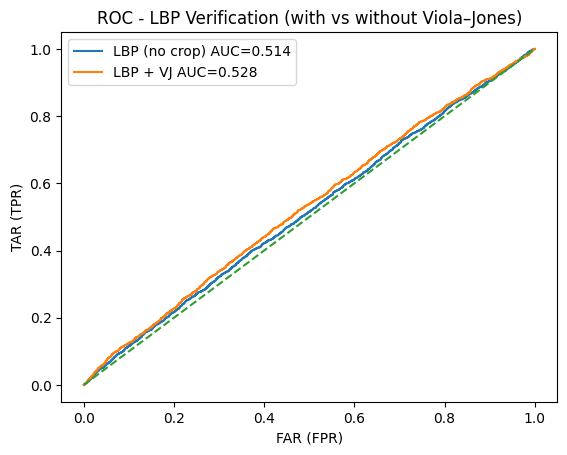

In [77]:
plt.figure()
plt.plot(fpr, tpr, label=f"LBP (no crop) AUC={results['methods']['LBP+SVM']['verification']['auc']:.3f}")
plt.plot(fpr_lbp_vj, tpr_lbp_vj, label=f"LBP + VJ AUC={auc_lbp_vj:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FAR (FPR)")
plt.ylabel("TAR (TPR)")
plt.title("ROC - LBP Verification (with vs without Viola–Jones)")
plt.legend()
plt.show()


DeepFace methods

In [79]:
!pip -q install deepface

from deepface import DeepFace

def deepface_embed(path, model_name, detector_backend="opencv"):
    '''
    Compute a DeepFace embedding (feature vector) for one image.

    Args:
      path: Path to the image.
      model_name: Backbone name, e.g. "Facenet512" or "ArcFace".
      detector_backend: Face detector backend used by DeepFace.
                        "opencv" is fast; stronger detectors may be slower but more accurate.

    Returns:
      emb: 1D numpy array embedding for the input image.
    '''
    rep = DeepFace.represent(
        img_path=path,
        model_name=model_name,
        detector_backend=detector_backend,
        enforce_detection=False
    )
    emb = np.array(rep[0]["embedding"], dtype=np.float32)
    return emb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/169.2 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/115.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/114.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/59.4 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 4.6 MB/s eta 0:00:00
26-01-28 01:19:13 - Directory /root/.deepface has been created
26-01-28 01:19:13 - Directory /root/.deepface/weights has been created


In [80]:
def build_embeddings(paths, model_name, detector_backend="opencv"):
    '''
    Compute DeepFace embeddings for a list of image paths.

    This uses DeepFace.represent() under the hood (pretrained models).
    We keep a simple cache (path -> embedding) to avoid recomputation.

    Args:
      paths: List of image paths.
      model_name: DeepFace model backbone name (e.g., "Facenet512", "ArcFace").
      detector_backend: Face detector backend used by DeepFace (e.g., "opencv").

    Returns:
      embs: 2D array (N, D) of embeddings.
      ms_per_img: Average time per image (milliseconds).
    '''
    cache = {}
    embs = []
    t0 = time.time()

    for p in paths:
        if p in cache:
            embs.append(cache[p])
        else:
            e = deepface_embed(p, model_name=model_name, detector_backend=detector_backend)
            cache[p] = e
            embs.append(e)

    embs = np.vstack(embs)
    ms_per_img = (time.time() - t0) * 1000 / len(paths)
    return embs, ms_per_img


In [81]:
from collections import defaultdict
from sklearn.metrics import accuracy_score

def fit_centroids(X, y):
    by = defaultdict(list)
    for xi, yi in zip(X, y):
        by[yi].append(xi)
    labels = sorted(by.keys())
    centroids = np.vstack([np.mean(by[l], axis=0) for l in labels])
    return labels, centroids

def predict_nearest_centroid(X, labels, centroids):
    # similarity
    # normalize
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    Cn = centroids / (np.linalg.norm(centroids, axis=1, keepdims=True) + 1e-12)
    sims = Xn @ Cn.T  # higher is better
    idx = np.argmax(sims, axis=1)
    return [labels[i] for i in idx]


In [82]:
def pair_scores_cosine(features, pairs):
    '''
    Compute cosine similarity scores for verification from embeddings.

    Higher cosine similarity => more similar.

    Args:
      features: 2D array (N, D), one embedding per image.
      pairs: Output of `make_pairs`.

    Returns:
      scores: 1D array of cosine similarity scores.
      y_true: 1D array of labels (1 genuine, 0 impostor).
    '''
    X = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-12)
    scores = []
    y_true = []
    for i, j, same in pairs:
        # cosine similarity
        s = float(np.dot(X[i], X[j]))
        scores.append(s)
        y_true.append(same)
    return np.array(scores), np.array(y_true)


In [83]:
MODEL = "Facenet512"
METHOD_KEY = "DeepFace-Facenet512"

# build embeddings
X_train_df, ms_train_df = build_embeddings(train_paths, model_name=MODEL, detector_backend="opencv")
X_test_df, ms_test_df = build_embeddings(test_paths, model_name=MODEL, detector_backend="opencv")

print("Embeddings shapes:", X_train_df.shape, X_test_df.shape)
print("DeepFace", MODEL, "ms/img train:", round(ms_train_df, 2), "test:", round(ms_test_df, 2))

# identification
labels_cent, centroids = fit_centroids(X_train_df, y_train)
pred = predict_nearest_centroid(X_test_df, labels_cent, centroids)
acc = accuracy_score(y_test, pred)
print("DeepFace", MODEL, "identification accuracy:", acc)

# store
results["methods"][METHOD_KEY]["identification"]["accuracy"] = float(acc)
results["methods"][METHOD_KEY]["runtime_ms"]["embed_train"] = float(ms_train_df)
results["methods"][METHOD_KEY]["runtime_ms"]["embed_test"] = float(ms_test_df)


26-01-28 01:19:41 - 🔗 facenet512_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5 to /root/.deepface/weights/facenet512_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5
100%|██████████| 95.0M/95.0M [00:01<00:00, 84.1MB/s]


Embeddings shapes: (1260, 512) (540, 512)
DeepFace Facenet512 ms/img train: 478.34 test: 455.58
DeepFace Facenet512 identification accuracy: 0.9259259259259259


In [84]:
from sklearn.metrics import roc_curve, auc
import numpy as np

pairs = make_pairs(y_test, max_genuine_per_id=200, max_impostor=5000, seed=42)
scores, y_true = pair_scores_cosine(X_test_df, pairs)

fpr, tpr, thr = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fpr - fnr))
eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
eer_thr = thr[eer_idx]

results["methods"][METHOD_KEY]["verification"]["auc"] = float(roc_auc)
results["methods"][METHOD_KEY]["verification"]["eer"] = float(eer)
results["methods"][METHOD_KEY]["verification"]["eer_threshold"] = float(eer_thr)
results["methods"][METHOD_KEY]["verification"]["far_at_eer"] = float(fpr[eer_idx])
results["methods"][METHOD_KEY]["verification"]["frr_at_eer"] = float(fnr[eer_idx])

print("DeepFace", MODEL, "AUC:", roc_auc)
print("DeepFace", MODEL, "EER:", eer)
print("DeepFace", MODEL, "FAR@EER:", float(fpr[eer_idx]), "FRR@EER:", float(fnr[eer_idx]))


DeepFace Facenet512 AUC: 0.9169174117647059
DeepFace Facenet512 EER: 0.14331176470588236
DeepFace Facenet512 FAR@EER: 0.1428 FRR@EER: 0.14382352941176468


ArcFace

In [85]:
MODEL = "ArcFace"
METHOD_KEY = "DeepFace-ArcFace"

X_train_df2, ms_train_df2 = build_embeddings(train_paths, model_name=MODEL, detector_backend="opencv")
X_test_df2, ms_test_df2 = build_embeddings(test_paths, model_name=MODEL, detector_backend="opencv")

print("Embeddings shapes:", X_train_df2.shape, X_test_df2.shape)
print("DeepFace", MODEL, "ms/img train:", round(ms_train_df2, 2), "test:", round(ms_test_df2, 2))

labels_cent2, centroids2 = fit_centroids(X_train_df2, y_train)
pred2 = predict_nearest_centroid(X_test_df2, labels_cent2, centroids2)
acc2 = accuracy_score(y_test, pred2)
print("DeepFace", MODEL, "identification accuracy:", acc2)

results["methods"][METHOD_KEY]["identification"]["accuracy"] = float(acc2)
results["methods"][METHOD_KEY]["runtime_ms"]["embed_train"] = float(ms_train_df2)
results["methods"][METHOD_KEY]["runtime_ms"]["embed_test"] = float(ms_test_df2)


26-01-28 01:33:46 - 🔗 arcface_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5 to /root/.deepface/weights/arcface_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:01<00:00, 88.4MB/s]


Embeddings shapes: (1260, 512) (540, 512)
DeepFace ArcFace ms/img train: 339.91 test: 337.92
DeepFace ArcFace identification accuracy: 0.9


In [86]:
pairs = make_pairs(y_test, max_genuine_per_id=200, max_impostor=5000, seed=42)
scores2, y_true2 = pair_scores_cosine(X_test_df2, pairs)

fpr2, tpr2, thr2 = roc_curve(y_true2, scores2)
roc_auc2 = auc(fpr2, tpr2)

fnr2 = 1 - tpr2
eer_idx2 = np.nanargmin(np.abs(fpr2 - fnr2))
eer2 = (fpr2[eer_idx2] + fnr2[eer_idx2]) / 2
eer_thr2 = thr2[eer_idx2]

results["methods"][METHOD_KEY]["verification"]["auc"] = float(roc_auc2)
results["methods"][METHOD_KEY]["verification"]["eer"] = float(eer2)
results["methods"][METHOD_KEY]["verification"]["eer_threshold"] = float(eer_thr2)
results["methods"][METHOD_KEY]["verification"]["far_at_eer"] = float(fpr2[eer_idx2])
results["methods"][METHOD_KEY]["verification"]["frr_at_eer"] = float(fnr2[eer_idx2])

print("DeepFace", MODEL, "AUC:", roc_auc2)
print("DeepFace", MODEL, "EER:", eer2)
print("DeepFace", MODEL, "FAR@EER:", float(fpr2[eer_idx2]), "FRR@EER:", float(fnr2[eer_idx2]))


DeepFace ArcFace AUC: 0.8865998235294117
DeepFace ArcFace EER: 0.18484705882352942
DeepFace ArcFace FAR@EER: 0.1844 FRR@EER: 0.18529411764705883


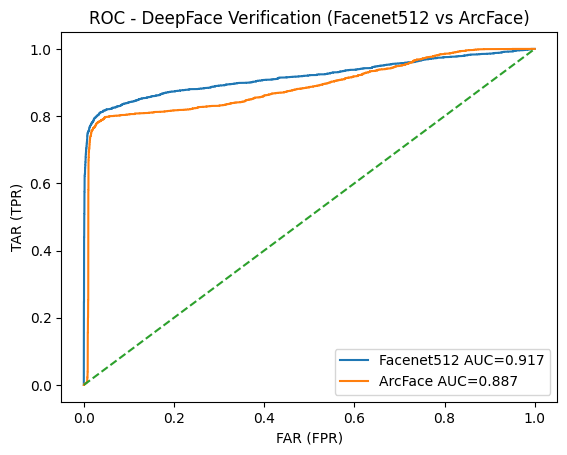

In [87]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"Facenet512 AUC={results['methods']['DeepFace-Facenet512']['verification']['auc']:.3f}")
plt.plot(fpr2, tpr2, label=f"ArcFace AUC={results['methods']['DeepFace-ArcFace']['verification']['auc']:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FAR (FPR)")
plt.ylabel("TAR (TPR)")
plt.title("ROC - DeepFace Verification (Facenet512 vs ArcFace)")
plt.legend()
plt.show()


### Interpretation and conclusion : Deep models vs classical descriptors
DeepFace backbones (ArcFace / Facenet512) compute **embeddings** that are designed to be robust to pose, illumination and background variation.

In practice, we expect:

- **Higher identification accuracy** than LBP/HOG on unconstrained photos.
- **Lower EER / higher AUC** in verification.

This matches the overall trend observed in modern face recognition systems: classical descriptors are lightweight but fragile; deep embeddings are heavier but substantially more robust.


In [88]:
import pandas as pd
import numpy as np

rows = []
for method_name, info in results.get("methods", {}).items():
    ident = info.get("identification", {})
    verif = info.get("verification", {})
    rt = info.get("runtime_ms", {})

    rows.append({
        "method": method_name,
        "kind": info.get("kind", ""),
        "acc": ident.get("accuracy", np.nan),
        "auc": verif.get("auc", np.nan),
        "eer": verif.get("eer", np.nan),
        "far@eer": verif.get("far_at_eer", np.nan),
        "frr@eer": verif.get("frr_at_eer", np.nan),
        # a few common runtime keys (will show NaN if missing)
        "ms/img_feat_train": rt.get("feature_train", np.nan),
        "ms/img_feat_test": rt.get("feature_test", np.nan),
        "ms/img_embed_train": rt.get("embed_train", np.nan),
        "ms/img_embed_test": rt.get("embed_test", np.nan),
    })

df = pd.DataFrame(rows)

# nicer ordering: best accuracy first
df = df.sort_values(by="acc", ascending=False)

df


,method,kind,acc,auc,eer,far@eer,frr@eer,ms/img_feat_train,ms/img_feat_test,ms/img_embed_train,ms/img_embed_test
2,DeepFace-Facenet512,deep,0.925926,0.916917,0.143312,0.1428,0.143824,NaN,NaN,478.344222,455.576293
3,DeepFace-ArcFace,deep,0.900000,0.886600,0.184847,0.1844,0.185294,NaN,NaN,339.908333,337.924735
5,HOG+SVM+VJ,,0.803704,0.577579,0.453271,0.4536,0.452941,106.990834,103.024753,NaN,NaN
1,HOG+SVM,classic,0.270370,NaN,NaN,NaN,NaN,6.515599,4.727272,NaN,NaN
0,LBP+SVM,classic,0.131481,0.514452,0.491929,0.4918,0.492059,18.258408,10.357932,NaN,NaN
4,LBP+SVM+VJ,,0.116667,0.528172,0.479306,0.4792,0.479412,106.437309,102.350960,NaN,NaN


## Reading the results table
- **acc**: identification accuracy (higher is better).
- **auc**: verification ROC area (higher is better, max = 1).
- **eer**: Equal Error Rate (lower is better, min = 0).
- **far@eer / frr@eer**: error rates at the EER operating point.

For time constraints:
- classical methods report `ms/img_feat_*`
- deep methods report `ms/img_embed_*`



In [90]:
df.to_csv("results_summary.csv", index=False)
print("Saved: results_summary.csv")


Saved: results_summary.csv


# Takeaway and commenting

## 3. Contraintes temps réel

### Coûts computationnels
A face recognition pipeline typically includes:
1) **Detection** (find the face)
2) **Feature extraction / embedding**
3) **Matching / decision**

- **LBP/HOG** are cheap and CPU-friendly (fast extraction, simple classifier).
- **DeepFace** is heavier: face detection + CNN forward pass per image. GPU makes this practical; CPU can be slow.

### Architectures adaptées au temps réel
To reach real-time constraints, common strategies are:
- **Lightweight CNNs** (e.g., MobileNet-like backbones)
- **Edge computing** (run on-device to reduce latency and improve privacy)
- **Hybrid** (detection on edge, recognition on server GPU)

### Compromis précision / rapidité
Our experiments illustrate the trade-off:
- classical descriptors: **fast** but **less robust** on unconstrained images
- deep embeddings: **more accurate/robust** but **computationally more expensive**

## 4. Explicabilité des modèles

### Limites des modèles “boîte noire”
Deep models produce embeddings through many layers; decisions are hard to interpret compared to hand-crafted descriptors.

### What we provide in this notebook
- For **LBP/HOG**, explainability is intrinsic: we can visualize the **LBP-coded image**, the **LBP histogram**, and a **HOG visualization** to show what patterns are encoded.
- For deep models, common approaches include **Grad-CAM** or **saliency maps**; these can be added as an extension if required.

## 5. Sécurité et attaques

### Main threats
- **Presentation attacks** (photo/screen replay)
- **Deepfakes**
- **Adversarial perturbations**

### Typical defenses
- **Multi-factor / multi-modal biometrics**
- **Secure template storage** (encryption, cancelable biometrics)
- **Robust training / anti-spoofing models**

## Key takeaways
- On full photos (background/outfits), **LBP/HOG identification accuracy is limited**.
- Face detection helps in principle, but **Viola–Jones may be unreliable** on unconstrained celebrity images.
- Deep embeddings provide the best robustness and verification performance under these conditions.
